##whether a blight ticket will be paid or not?
#1 Introduction
This project is based on a data challenge from the Michigan Data Science Team(MDST). It is also a final project from the coursera online course,  Applied machine learning in Python from University of Michigan. 
The Michigan Data Science Team (MDST) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences (MSSISS) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. Blight violations are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?
So the first step in answering this question is understanding and predicting whether a resident may fail to comply with a blight ticket. In this project, I will look into the dataset provided by the Detroit Open Data Portal. I will select features from the data and used a widely-used assemble method, gradient boosting to predict the label of the test set. 


In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
print(os.listdir("../input"))



['latlons.csv', 'train.csv', 'test.csv', 'addresses.csv']


#2 look into the data
As usual, the first thing to do is to have a first insight of the data.

In [2]:
path = "../input/"
train_data = pd.read_csv(path+"train.csv",encoding="ISO-8859-1")
test_data = pd.read_csv(path+"test.csv")
address = pd.read_csv(path+"addresses.csv")
location = pd.read_csv(path+"latlons.csv")

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


For the training set, the index is the ticket_id. We usually will not include it as a feature in machine learning model since it doesn't include extra information. (In some special cases we may need to do that when the ids have other indications.) I already saw some invalid values in some of the features, and I will deal with them later. Some of the features are categorical, while some of them are numerical values.

In [3]:
# take a look at the data
train_data=train_data.set_index('ticket_id')
train_data.head()

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
ticket_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,MI,48223,NaN,USA,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,MI,48214,NaN,USA,2004-04-26 13:30:00,NaN,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,MI,48206,NaN,USA,2004-04-26 13:00:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


For the test set, I found there are different features in training set and test set. We need to find them. Sometimes we can make up features for test set if it is missing some features in training set. But in most of time, it is very hard to do so. So we will merely pay attention to the features in both trainning set and test set. 

In [4]:
test_data = test_data.set_index('ticket_id')
test_data.head()

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
ticket_id,,,,,,,,,,,,,,,,,,,,,,,,,,
284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,MI,48213,NaN,USA,2012-01-04 14:00:00,2012-01-19 09:00:00,22-2-61,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,MI,48219,NaN,USA,2012-01-05 09:50:00,2012-02-06 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,MI,48219,NaN,USA,2012-01-05 09:50:00,2012-02-06 09:00:00,22-2-43,Improper placement of Courville container betw...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,MI,48183,NaN,USA,2012-01-05 10:25:00,2012-02-07 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,MI,48154,NaN,USA,2012-01-05 10:20:00,2012-02-14 09:00:00,22-2-45,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN


The address dataset is very easy. It only consists of an address fro each ticket_id. We can merge it into trainning and test very easily. 

In [5]:
address.head()


,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"
3,22084,"1441 longfellow, Detroit MI"
4,22093,"2449 churchill, Detroit MI"


The location set is also easy. It has one latitude and one longitude for each address

In [6]:
location.head()

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295


So firstly I will merge the latitude and longitude into the address dataset. You may ask since we already have the information of address, is latitude and longitude redundant here?
I think it provides us extra information. With address, we only know which street or which house  the person who receives the ticket is living. But the address looks identical to us, expecially when two addresses are in the same city. But with the information of latitude and longitude, we may could group the addresses that are near each other together. For instance, people live in an upscale community may tend to pay the fine on time. On the other hand, people in ordinary comunity may tend to pay the ticket late. It is just my initial and intutive guess on the data. But for sure, the latitude and longitude provides us extra information.

In [7]:
# merge address and location
address=address.set_index('address')
location=location.set_index('address')
address = address.join(location,how="left")
address

,ticket_id,lat,lon
address,,,
"-11064 gratiot, Detroit MI",328722,42.406935,-82.995599
"-11871 wilfred, Detroit MI",350971,42.411288,-82.993674
"-15126 harper, Detroit MI",344821,42.406402,-82.957525
"0 10th st, Detroit MI",24928,42.325689,-83.064330
"0 10th st, Detroit MI",71887,42.325689,-83.064330
"0 10th st, Detroit MI",157969,42.325689,-83.064330
"0 10th st, Detroit MI",168151,42.325689,-83.064330
"0 10th st, Detroit MI",195261,42.325689,-83.064330
"0 10th st, Detroit MI",197008,42.325689,-83.064330


After the transfer, I reset ticket ID as the index of address dataset.

In [8]:
# reset the index of address to ticket ID

new_address=address.reset_index(drop=False)
new_address=new_address.set_index("ticket_id")
new_address.head()

,address,lat,lon
ticket_id,,,
328722,"-11064 gratiot, Detroit MI",42.406935,-82.995599
350971,"-11871 wilfred, Detroit MI",42.411288,-82.993674
344821,"-15126 harper, Detroit MI",42.406402,-82.957525
24928,"0 10th st, Detroit MI",42.325689,-83.064330
71887,"0 10th st, Detroit MI",42.325689,-83.064330


Then I merged the address dataset into trainning and test using the very convient function "merge" in Pandas. 
I also print the size of the training set before and after merging. The three extra columns are just "address", "lat", and "lon".

In [9]:
# we need to merge train and test with address
Total_train = pd.merge(train_data,new_address,how='left',left_index=True,right_index=True)
print(Total_train.shape)
print(train_data.shape)
Total_train.head()

(250306, 36)
(250306, 33)


,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
ticket_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,48208,NaN,USA,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI",42.326937,-83.135118
22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,MI,48223,NaN,USA,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1449 longfellow, Detroit MI",42.380516,-83.096069
22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,MI,48214,NaN,USA,2004-04-26 13:30:00,NaN,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"1441 longfellow, Detroit MI",42.380570,-83.095919
22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,MI,48206,NaN,USA,2004-04-26 13:00:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"2449 churchill, Detroit MI",42.145257,-83.208233


Do the same thing for the test set. ALso notice after merge, the test set only has 29 columns. We need to find the columns only appear in train or test.

In [10]:
Total_test = pd.merge(test_data,new_address,how='left',left_index=True,right_index=True)
print(Total_test.shape)
print(test_data.shape)
Total_test.head()

(61001, 29)
(61001, 26)


,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status,address,lat,lon
ticket_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,MI,48213,NaN,USA,2012-01-04 14:00:00,2012-01-19 09:00:00,22-2-61,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN,"10041 roseberry, Detroit MI",42.407581,-82.986642
285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,MI,48219,NaN,USA,2012-01-05 09:50:00,2012-02-06 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN,"18520 evergreen, Detroit MI",42.426239,-83.238259
285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,MI,48219,NaN,USA,2012-01-05 09:50:00,2012-02-06 09:00:00,22-2-43,Improper placement of Courville container betw...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN,"18520 evergreen, Detroit MI",42.426239,-83.238259
285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,MI,48183,NaN,USA,2012-01-05 10:25:00,2012-02-07 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN,"1835 central, Detroit MI",42.309661,-83.122426
285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,MI,48154,NaN,USA,2012-01-05 10:20:00,2012-02-14 09:00:00,22-2-45,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN,"1700 central, Detroit MI",42.308830,-83.121116


The column "compliance" in the training set is the label of each observation. And it is the label we need to predict for test set. 
Here I just extract it and put it aside.

In [11]:
#Note we need to save the label "compliance" aside
Total_train=Total_train.dropna(subset=['compliance'])
Total_train['compliance'] = Total_train['compliance'].astype(int)
label = Total_train['compliance']
print(label)

ticket_id
22056     0
27586     1
22046     0
18738     0
18735     0
18733     0
28204     0
18743     0
18741     0
18978     0
18746     1
18744     1
26846     0
26848     0
28209     0
19950     0
18645     0
18651     0
18649     0
18664     0
18646     0
18661     0
18657     1
18652     0
18665     0
18650     0
18653     1
18658     0
18666     0
18655     1
         ..
268081    0
267964    0
267966    0
267974    0
267985    0
267970    0
284870    0
284873    0
284871    0
284875    0
284874    0
285091    0
285508    1
285093    0
285095    0
285121    0
285122    0
285120    0
285123    0
285092    0
285094    0
285096    0
285036    0
285037    0
285034    0
285106    0
284650    0
285125    0
284881    1
284333    0
Name: compliance, Length: 159880, dtype: int64


##2 feature selection and engineeering
Now I begin to detect which features are only in trainning set, and which are only in test set. 
I found there are 7 features only appear in trainning set. One of them is naturally the predcited label "Compliance".
There are other six features. And unfortunately it is impossible to create or make them up in test set. So I choose to drop them.
There is no feature that only appear in test set, which saves us some time. 

In [12]:
# we need to delete those features that only in train or test
list_to_remove_train=[]
list_to_remove_test=[]
for column in Total_train.columns:
    if column not in Total_test.columns:
        list_to_remove_train.append(column)

        
for column in Total_test.columns:
    if column not in Total_train.columns:
        list_to_remove_test.append(column)
        
print(list_to_remove_train)        
print(list_to_remove_test)

# so we only to remove some features from train

Total_train=Total_train.drop(list_to_remove_train,axis=1)

['payment_amount', 'balance_due', 'payment_date', 'payment_status', 'collection_status', 'compliance_detail', 'compliance']
[]


After that, I need to check how many invalid observations in each feature both in trainning set and test set. 
I found there are three features where more than 50% of data is missing. So I will drop them.

In [13]:
Total_train.isnull().sum()
#We have three features almost are all invalid values, so we need to delete them.


agency_name                        0
inspector_name                     0
violator_name                     26
violation_street_number            0
violation_street_name              0
violation_zip_code            159880
mailing_address_str_number      2558
mailing_address_str_name           3
city                               0
state                             84
zip_code                           1
non_us_str_code               159877
country                            0
ticket_issued_date                 0
hearing_date                     227
violation_code                     0
violation_description              0
disposition                        0
fine_amount                        0
admin_fee                          0
state_fee                          0
late_fee                           0
discount_amount                    0
clean_up_cost                      0
judgment_amount                    0
grafitti_status               159880
address                            0
l

In [14]:
Total_test.isnull().sum()

agency_name                       0
inspector_name                    0
violator_name                    28
violation_street_number           0
violation_street_name             0
violation_zip_code            36977
mailing_address_str_number     1014
mailing_address_str_name          3
city                              1
state                           331
zip_code                          3
non_us_str_code               61001
country                           0
ticket_issued_date                0
hearing_date                   2197
violation_code                    0
violation_description             0
disposition                       0
fine_amount                       0
admin_fee                         0
state_fee                         0
late_fee                          0
discount_amount                   0
clean_up_cost                     0
judgment_amount                   0
grafitti_status               58780
address                           0
lat                         

In [15]:
list_to_remove_both = ['violation_zip_code','non_us_str_code','grafitti_status']
Total_train=Total_train.drop(list_to_remove_both,axis=1)
Total_test=Total_test.drop(list_to_remove_both,axis=1)

We can try to do some plot to investigate whether some of those features are correlated to the data label.
In those figures below, I made several Gaussian kernel density estimate plots to visualize the effect of the features on the target. It is showing the distribution of a single varible and can be thought of as a smoothed histogram. I used the seaborn kdeplot for those graphs.

But in those figures, I didn't observe very obvious trends. I didn't see one curve skewing towards one end of the range. In the plot of Longitude distribution, I do see some regions have higher probability to have the tickets paid on time, and some regions have higher probability for a late payment. But in a word, no obvious decisions can be made based on those graphs.


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


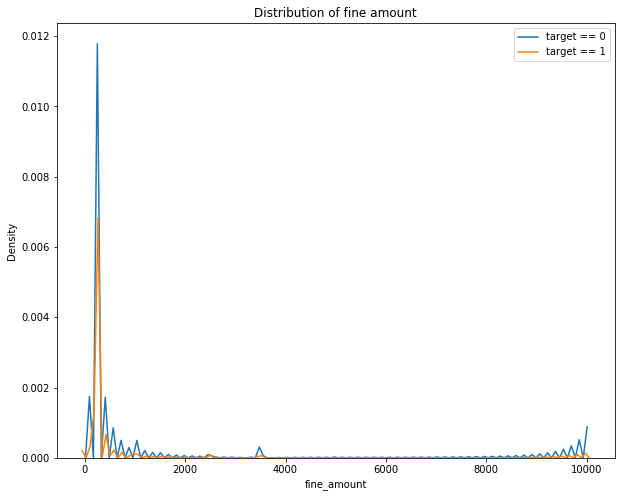

In [16]:
Total_train['TARGET'] = label

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(Total_train.loc[Total_train['TARGET'] == 0, 'fine_amount'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(Total_train.loc[Total_train['TARGET'] == 1, 'fine_amount'], label = 'target == 1')

# Labeling of plot
plt.xlabel('fine_amount'); plt.ylabel('Density'); plt.title('Distribution of fine amount');

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


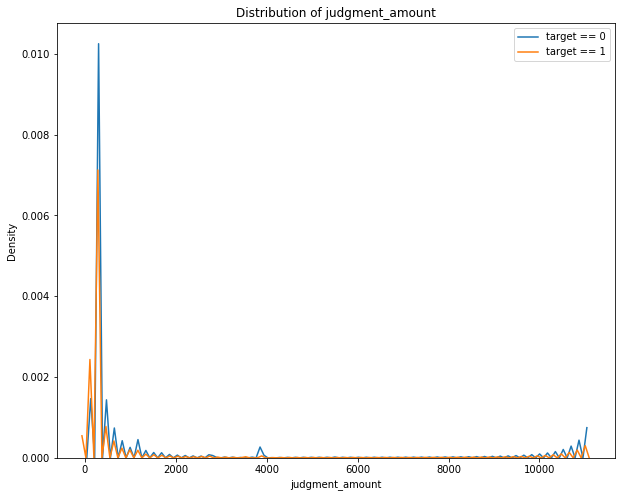

In [17]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(Total_train.loc[Total_train['TARGET'] == 0, 'judgment_amount'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(Total_train.loc[Total_train['TARGET'] == 1, 'judgment_amount'], label = 'target == 1')

# Labeling of plot
plt.xlabel('judgment_amount'); plt.ylabel('Density'); plt.title('Distribution of judgment_amount');

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


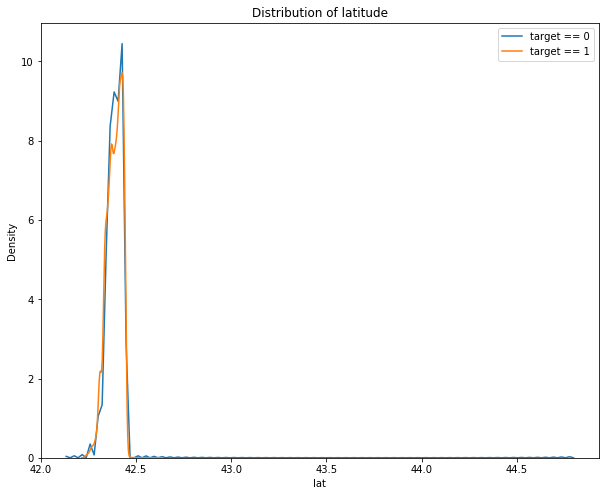

In [18]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(Total_train.loc[Total_train['TARGET'] == 0, 'lat'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(Total_train.loc[Total_train['TARGET'] == 1, 'lat'], label = 'target == 1')

# Labeling of plot
plt.xlabel('lat'); plt.ylabel('Density'); plt.title('Distribution of latitude');

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


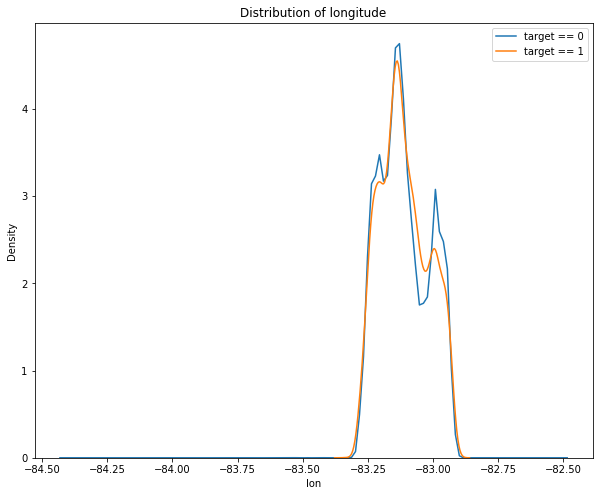

In [19]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(Total_train.loc[Total_train['TARGET'] == 0, 'lon'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(Total_train.loc[Total_train['TARGET'] == 1, 'lon'], label = 'target == 1')

# Labeling of plot
plt.xlabel('lon'); plt.ylabel('Density'); plt.title('Distribution of longitude');

So I turned to correlation coefficients for help. Here I calculated the pair-wise correlation coefficients for all those
features having numerical values. I observed some interesting things. Firstly there are some invalid values in the table below.
That is because some features have only one unique value, and therefore they have a zero variance and an invalid correlation 
coefficient. We definitely do not need those features. Another thing is the correlation between fine amount and judgment amount is almost 1. That means there is collinearity in these two features. We need to drop one of them. Late fee is in a similiar condition. 
For other features, though the correlation between them and the target is very small. It is still be regarded as useful features in machine learning since 
it does affect the target. 


In [20]:
ext_data = Total_train[['agency_name', 'inspector_name', 'violator_name',
        'fine_amount','admin_fee', 'state_fee', 'late_fee', 'discount_amount',
       'clean_up_cost', 'judgment_amount', 'address', 'lat',
       'lon','TARGET']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,lat,lon,TARGET
fine_amount,1.000000,NaN,NaN,0.986787,0.039495,NaN,0.999890,-0.002891,-0.024070,-0.049134
admin_fee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state_fee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
late_fee,0.986787,NaN,NaN,1.000000,-0.022706,NaN,0.989070,0.000514,-0.022727,-0.085055
discount_amount,0.039495,NaN,NaN,-0.022706,1.000000,NaN,0.033869,0.000261,-0.006432,0.156073
clean_up_cost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
judgment_amount,0.999890,NaN,NaN,0.989070,0.033869,NaN,1.000000,-0.002592,-0.023963,-0.052637
lat,-0.002891,NaN,NaN,0.000514,0.000261,NaN,-0.002592,1.000000,0.175336,-0.021569
lon,-0.024070,NaN,NaN,-0.022727,-0.006432,NaN,-0.023963,0.175336,1.000000,-0.000431
TARGET,-0.049134,NaN,NaN,-0.085055,0.156073,NaN,-0.052637,-0.021569,-0.000431,1.000000


In [21]:

Total_train = Total_train.drop(['TARGET'],axis=1)

Other than the three features that missing too much data. I also choose to drop more features. 
Introducing many features in one machine learning model will surely increase the complexity of the model. 
And therefore it is easier to induce overfitting. Besides, some features will not provide useful information but will 
introduce bias into the model. 
Here, I droped the features "zip_code", 'mailing_address_str_number',and 'mailing_address_str_name' because those information has already been 
covered by address, latitude and longitude. These three features are providing redundant information. 
The feature 'Country' is also useless since all the violations should happened in United States.But I checked and see there are very weird values like
"Germ" and "Egyp" in "Country". But for safe I choose to delete it. 
"ticket_issued_date", "hearing_date", "violator_name" ,"violate_street_number", and "violate_street_name" are all very sparse features with a relative large number of unique values in this dataset. But I choose to keep them for now since I don't want to make too many arbitary decisions.
I also want to discard the feature "inspector_name" by intuitive since I don't think when people decide whether pay a ticket or not, they will know or remember the name of the inspector who issued the ticket. It is definitely not a key factor in this project. 
In a word, I don't want to discard features just based on my intuition and arbitary decisions. So I will keep  most of the categorical features for now. 

In [22]:
print(Total_train.nunique())
for column in Total_train:
    print (Total_train[column].unique())

agency_name                       5
inspector_name                  159
violator_name                 84656
violation_street_number       18096
violation_street_name          1716
mailing_address_str_number    14090
mailing_address_str_name      28440
city                           4093
state                            59
zip_code                       4622
country                           5
ticket_issued_date            68097
hearing_date                   5970
violation_code                  189
violation_description           207
disposition                       4
fine_amount                      40
admin_fee                         1
state_fee                         1
late_fee                         37
discount_amount                  13
clean_up_cost                     1
judgment_amount                  57
address                       71901
lat                           61559
lon                           66839
dtype: int64
['Buildings, Safety Engineering & Env Department' '

['2900 tyler, Detroit MI' '4311 central, Detroit MI'
 '6478 northfield, Detroit MI' ... '14425 grandmont, Detroit MI'
 '20009 northlawn, Detroit MI' '7152 chicago, Detroit MI']
[42.390729  42.3269371 42.145257  ... 42.393397  42.4402281 42.3665291]
[-83.124268  -83.1351183 -83.208233  ... -83.214473  -83.211176
 -83.1418966]


In [23]:
# besides that, we also need to delete those features
# having duplicate information and contains useless information
list_to_remove_both = [ 'zip_code','country','judgment_amount',
                        'admin_fee', 'state_fee', 'late_fee','clean_up_cost',
                        'mailing_address_str_number',
                        'mailing_address_str_name',
                        ]

Total_train=Total_train.drop(list_to_remove_both,axis=1)
Total_test=Total_test.drop(list_to_remove_both,axis=1)
print(Total_train.shape)
print(Total_test.shape)

(159880, 17)
(61001, 17)


In [24]:
Total_train.head()

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,city,state,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,discount_amount,address,lat,lon
ticket_id,,,,,,,,,,,,,,,,,
22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,CHICAGO,IL,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,Detroit,MI,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,0.0,"4311 central, Detroit MI",42.326937,-83.135118
22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478.0,NORTHFIELD,LOG BEACH,CA,2004-05-01 11:50:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,0.0,"6478 northfield, Detroit MI",42.145257,-83.208233
18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",8027.0,BRENTWOOD,Clinton,MI,2004-06-14 14:15:00,2005-02-22 15:00:00,61-63.0500,Failed To Secure Permit For Lawful Use Of Land,Responsible by Default,750.0,0.0,"8027 brentwood, Detroit MI",42.433466,-83.023493
18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,Detroit,MI,2004-06-16 12:30:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,100.0,0.0,"8228 mt elliott, Detroit MI",42.388641,-83.037858


We always need to deal with the invalid values otherwise no machine learning model will work on the dataset. 

In [25]:
# before fit a model, we need to dealwith the invalid value, rescale
#the data, and transfer all the data into numerical values.


from sklearn.preprocessing import MinMaxScaler
Total_train.fillna(method='pad', inplace=True)
Total_test.fillna(method='pad', inplace=True)


In order to make our model work, we also need to transfer all the categorical features into numerical values.
Also we need to normalize all the features to avoid the impact of different scales of different features on the model performance.

In [26]:
need_to_transfer=[]
for column in Total_train.columns:
    if Total_train[column].dtypes == "object":
        need_to_transfer.append(column)
print(need_to_transfer)

['agency_name', 'inspector_name', 'violator_name', 'violation_street_name', 'city', 'state', 'ticket_issued_date', 'hearing_date', 'violation_code', 'violation_description', 'disposition', 'address']


In [27]:
# we have in total 5 features in category type
train_objs_num=len(Total_train)
Total_train_test = pd.concat(objs=[Total_train,Total_test],axis=0)
print(Total_train_test.head(10))

    
from sklearn import preprocessing
for column in need_to_transfer:
    le_temp = preprocessing.LabelEncoder()
    le_temp.fit(Total_train_test[column])
    Total_train_test[column] = le_temp.transform(Total_train_test[column])
#Total_train_test=pd.get_dummies(Total_train_test,columns=need_to_transfer)
scaler = MinMaxScaler()
Total_train_test=pd.DataFrame(scaler.fit_transform(Total_train_test),columns=Total_train.columns)
#print(time.time())
print(Total_train_test)


                                              agency_name    ...            lon
ticket_id                                                    ...               
22056      Buildings, Safety Engineering & Env Department    ...     -83.124268
27586      Buildings, Safety Engineering & Env Department    ...     -83.135118
22046      Buildings, Safety Engineering & Env Department    ...     -83.208233
18738      Buildings, Safety Engineering & Env Department    ...     -83.023493
18735      Buildings, Safety Engineering & Env Department    ...     -83.037858
18733      Buildings, Safety Engineering & Env Department    ...     -83.037858
28204      Buildings, Safety Engineering & Env Department    ...     -82.963348
18743      Buildings, Safety Engineering & Env Department    ...     -83.022333
18741      Buildings, Safety Engineering & Env Department    ...     -83.180488
18978      Buildings, Safety Engineering & Env Department    ...     -83.023161

[10 rows x 17 columns]
        agency_n

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Here I fit a simple tree model to calculate the feature importances for the remain features. And based on that we can determine whether to keep or discard one feature. 
From the plot of features importances, I can see there two features has outstanding importances, which means they contribute the most to the result.
Those two features are disposition and discount_amount, which both make full sense to me. Another three features also have significant contribution to the result. They are hearing_date, fine_amount, and ticket_issued_date. 

[3.35574845e-04 1.52188661e-03 2.61573301e-03 1.16924659e-03
 2.34078938e-03 3.14283840e-03 4.82403152e-04 5.74211214e-02
 7.36475465e-02 7.15038409e-03 2.97709682e-03 4.10885034e-01
 7.33174365e-02 3.48005446e-01 1.84366229e-03 7.03306608e-03
 6.11073372e-03]
Index(['agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name', 'city', 'state',
       'ticket_issued_date', 'hearing_date', 'violation_code',
       'violation_description', 'disposition', 'fine_amount',
       'discount_amount', 'address', 'lat', 'lon'],
      dtype='object')
Feature ranking:
1. feature 11 (0.410885)
2. feature 13 (0.348005)
3. feature 8 (0.073648)
4. feature 12 (0.073317)
5. feature 7 (0.057421)
6. feature 9 (0.007150)
7. feature 15 (0.007033)
8. feature 16 (0.006111)
9. feature 5 (0.003143)
10. feature 10 (0.002977)
11. feature 2 (0.002616)
12. feature 4 (0.002341)
13. feature 14 (0.001844)
14. feature 1 (0.001522)
15. feature 3 (0.001169)
16. feature 6 (0.

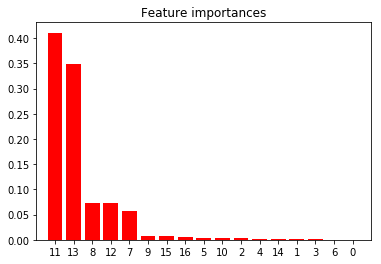

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
X_train_scaled = Total_train_test[:train_objs_num]
y_train = label
X_test_scaled=Total_train_test[train_objs_num:]
initial_tree = GradientBoostingClassifier(random_state=0)
initial_tree.fit(X_train_scaled,y_train)
print(initial_tree.feature_importances_)
print(X_train_scaled.columns)
importances = initial_tree.feature_importances_
std = np.std([initial_tree.feature_importances_ for tree in initial_tree.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")



for f in range(X_train_scaled.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_scaled.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), indices)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()


Now we will train two models. One is using the five most significant features. The other will use all the features. And we can compare these two models.
You may notice that with the only five significant features, the area under roc curve is only 0.75. However, with all the features, it increased to 0.78.
So although those features contribute minorly to final results, they still have effect on our model. And the effect of the sum of those feaatures cannot be ignored. 
In conclusion, if we have many features(let's say thousands or tens of thousands), the feature importance can help us filter some features. In this project, we only have 
less than 20 features in total. So there is no significant improvement. 

In [29]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
features_to_use =['disposition','discount_amount','hearing_date','fine_amount','ticket_issued_date']
X_train1 = X_train_scaled[features_to_use]
y_train1 = y_train
X_test1 = X_test_scaled[features_to_use]
print(X_train1)
print(X_test1)
grid_values={'learning_rate':[0.001,0.01,0.1,1],'max_depth':[2,3,5,10]}
model2=GradientBoostingClassifier(random_state=0)
grid_model2_auc=GridSearchCV(model2,param_grid=grid_values,scoring='roc_auc')
grid_model2_auc.fit(X_train1,y_train)
print(grid_model2_auc.best_params_)
print(grid_model2_auc.best_score_)
print(grid_model2_auc.cv_results_)
test_proba = grid_model2_auc.predict_proba(X_test1)[:,1]
result=pd.Series(test_proba,index=Total_test.index)

        disposition         ...          ticket_issued_date
0          0.714286         ...                    0.000010
1          0.857143         ...                    0.000020
2          0.714286         ...                    0.000030
3          0.714286         ...                    0.000040
4          0.714286         ...                    0.000059
5          0.714286         ...                    0.000049
6          0.714286         ...                    0.000069
7          0.714286         ...                    0.000079
8          0.714286         ...                    0.000089
9          0.714286         ...                    0.000099
10         0.857143         ...                    0.000109
11         0.857143         ...                    0.000109
12         0.714286         ...                    0.000119
13         0.714286         ...                    0.000129
14         0.714286         ...                    0.000138
15         0.571429         ...         

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:829: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.1, 'max_depth': 2}
0.7454084535033944
{'mean_fit_time': array([ 3.0106593 ,  3.99046119,  6.41796343, 22.4750247 ,  2.87359158,
        3.92661484,  6.66997894, 23.86291138,  2.87153363,  3.89907344,
        6.65601484, 23.32685161,  2.81880601,  3.87104519,  6.51296997,
       26.33441305]), 'std_fit_time': array([0.0730251 , 0.13179282, 0.43676334, 3.38537955, 0.05616262,
       0.11663278, 0.21684593, 3.04502404, 0.05305249, 0.05390103,
       0.02153168, 0.6222541 , 0.02131782, 0.07721899, 0.24902884,
       0.81976431]), 'mean_score_time': array([0.04534189, 0.05577278, 0.09236495, 0.13551442, 0.04461273,
       0.05867704, 0.0908281 , 0.14006495, 0.0442663 , 0.0548621 ,
       0.08904632, 0.16979249, 0.04038143, 0.05478994, 0.07400052,
       0.1730001 ]), 'std_score_time': array([0.00254043, 0.00341337, 0.02261123, 0.05283522, 0.00012645,
       0.0016517 , 0.01623278, 0.05292149, 0.0017516 , 0.00238064,
       0.00587166, 0.02448674, 0.00460461, 0.00405025, 

In [30]:

X_train1 = X_train_scaled
y_train1 = y_train
X_test1 = X_test_scaled
print(X_train1)
print(X_test1)
grid_values={'learning_rate':[0.001,0.01,0.1,1],'max_depth':[2,3,5,10]}
model2=GradientBoostingClassifier(random_state=0)
grid_model2_auc=GridSearchCV(model2,param_grid=grid_values,scoring='roc_auc')
grid_model2_auc.fit(X_train1,y_train)
print(grid_model2_auc.best_params_)
print(grid_model2_auc.best_score_)
print(grid_model2_auc.cv_results_)
test_proba = grid_model2_auc.predict_proba(X_test1)[:,1]
result=pd.Series(test_proba,index=Total_test.index)

        agency_name  inspector_name    ...          lat       lon
0              0.00        0.796296    ...     0.092977  0.676686
1              0.00        0.962963    ...     0.068815  0.670948
2              0.00        0.796296    ...     0.000000  0.632280
3              0.00        0.962963    ...     0.109165  0.729983
4              0.00        0.962963    ...     0.092186  0.722386
5              0.00        0.962963    ...     0.092186  0.722386
6              0.00        0.962963    ...     0.110038  0.761791
7              0.00        0.962963    ...     0.094885  0.730596
8              0.00        0.962963    ...     0.111711  0.646953
9              0.00        0.962963    ...     0.096194  0.730158
10             0.00        0.962963    ...     0.081655  0.778922
11             0.00        0.962963    ...     0.081655  0.778922
12             0.00        0.962963    ...     0.074418  0.603715
13             0.00        0.962963    ...     0.074376  0.675021
14        

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:829: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.1, 'max_depth': 2}
0.7833336849951851
{'mean_fit_time': array([  7.41587567,  11.13059632,  21.46620655, 105.3470126 ,
         7.3567764 ,  11.44640628,  22.29012577, 115.23871446,
         7.38379637,  11.45847829,  22.98383959, 110.88783518,
         7.40677746,  11.3914686 ,  22.04502559,  74.17279299]), 'std_fit_time': array([ 0.2378822 ,  0.36192321,  1.20408555, 17.35033664,  0.13885364,
        0.39084218,  0.62822507, 21.28003538,  0.07058488,  0.16044168,
        0.65187682,  5.85464236,  0.2443408 ,  0.27642617,  1.5890549 ,
        9.39207503]), 'mean_score_time': array([0.04842385, 0.06225928, 0.09806657, 0.15525254, 0.04881223,
       0.0616986 , 0.09849715, 0.15880609, 0.05256009, 0.0698127 ,
       0.10660871, 0.20332336, 0.04886707, 0.06508334, 0.09795252,
       0.19828924]), 'std_score_time': array([0.00298719, 0.00079734, 0.02223645, 0.05764163, 0.00328038,
       0.00313364, 0.01954328, 0.06119827, 0.00093783, 0.00280091,
       0.00736487, 0.00

In this project, the true complaince data is not provided. So I cannot plot the roc curve of test set. Instead I plotted 
the roc curve of training set. It is not perfect but still acceptable and much better than the baseline.

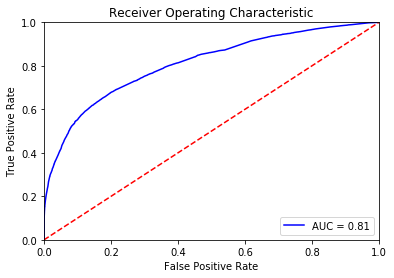

ticket_id
284932    0.106825
285362    0.039425
285361    0.106298
285338    0.091753
285346    0.104404
285345    0.091753
285347    0.096493
285342    0.610559
285530    0.034069
284989    0.049085
285344    0.094821
285343    0.038238
285340    0.035543
285341    0.091753
285349    0.104404
285348    0.091753
284991    0.049085
285532    0.046090
285406    0.052084
285001    0.046090
285006    0.035948
285405    0.041040
285337    0.053231
285496    0.101634
285497    0.101634
285378    0.041040
285589    0.055379
285585    0.099059
285501    0.105620
285581    0.039425
            ...   
376367    0.056398
376366    0.083152
376362    0.567761
376363    0.621000
376365    0.056398
376364    0.083152
376228    0.091182
376265    0.083245
376286    0.332724
376320    0.083152
376314    0.083152
376327    0.321919
376385    0.332724
376435    0.460150
376370    0.583364
376434    0.106825
376459    0.101634
376478    0.037683
376473    0.083152
376484    0.053619
376482    0.064505
37

In [39]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
# make output with the best parameters
model2_best = GradientBoostingClassifier(random_state=0,learning_rate=0.1,max_depth=2)
model2_best.fit(X_train_scaled,y_train)
train_proba=model2_best.predict_proba(X_train_scaled)[:,1]
#y_test = model2_best.predict(X_test_scaled)
fpr, tpr, threshold = roc_curve(y_train, train_proba)
roc_auc=auc(fpr,tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


test_proba=model2_best.predict_proba(X_test_scaled)[:,1]
result=pd.Series(test_proba,index=Total_test.index)
print(result)


##3 Conclusion
Here achieved a area under roc curve of 0.78, which is acceptable for a project like this. The whole process is just a very standard data analysis and modeling
process. We found two key features in training set: deposition and discount amount. A gradient boosting model was developped for prediction.